In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

--2023-03-15 07:36:22--  http://download.geofabrik.de/europe/sweden-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.48.72, 65.109.50.43
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.48.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657808154 (627M) [application/octet-stream]
Saving to: ‘sweden-latest.osm.pbf’

sweden-latest.osm.p 100%[===================>] 627.33M  86.4MB/s    in 7.3s    

2023-03-15 07:36:29 (85.9 MB/s) - ‘sweden-latest.osm.pbf’ saved [657808154/657808154]



In [3]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [43]:
len(buildinghandler.buildings)

2026058

In [44]:
psutil.virtual_memory().percent

12.4

In [45]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    #gdfx = gdfx.cx[672236:676942, 6577855:6579891]
    gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(3891, 3)
(5168, 3)
(6180, 3)
(6930, 3)
(7860, 3)
(8885, 3)
(11312, 3)
(11984, 3)
(12926, 3)
(13706, 3)


In [54]:
reg = meta[meta['building:levels'].str.contains('[A-Za-z]') == False]
reg = reg[reg['building:levels'].str.contains('[;-]') == False]

In [55]:
reg.shape

(13700, 3)

In [56]:
y = reg['building:levels'].astype(float)
x = reg.area

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    x, y, train_size=8000, random_state=42, shuffle=True
)

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
model = LinearRegression()

In [60]:
import numpy as np
model.fit(np.array(X_train).reshape(-1,1), y_train)

LinearRegression()

In [61]:
from sklearn.metrics import mean_squared_error
import math
predict_y = model.predict(np.array(X_test).reshape(-1,1))
rmse = math.sqrt(mean_squared_error(y_test,predict_y))
rmse

1.7578397665848287

In [62]:
#computing scatter indexs
rmse / y.mean() * 100
#and it is very high - the model is not a good one

85.0622708164956

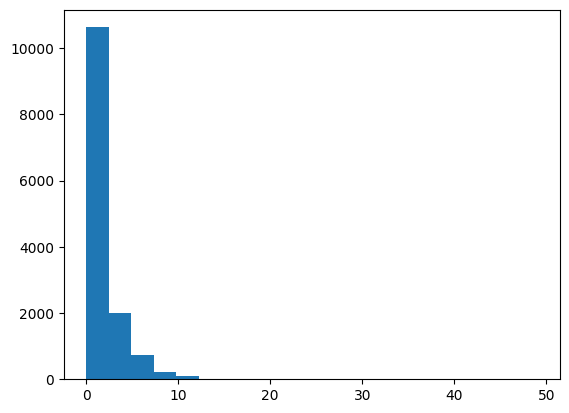

In [63]:
plt.hist(y, bins=20)
plt.show()

Text(0.5, 1.0, 'Correlation for buildingarea and levels, Sweden')

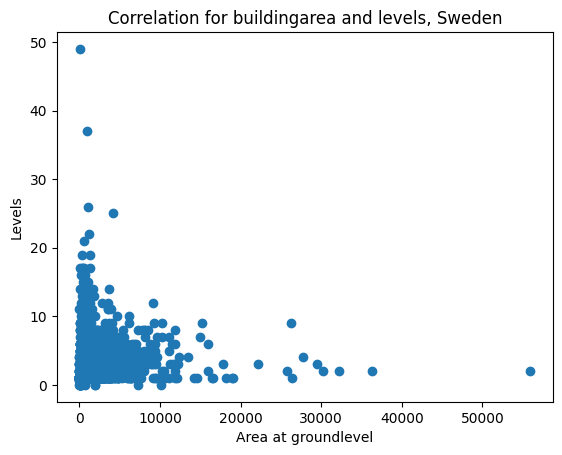

In [68]:
#scatter plotting to inspect the correlation between area and levels
plt.scatter(x, y)
plt.ylabel('Levels')
plt.xlabel('Area at groundlevel')
plt.title('Correlation for buildingarea and levels, Sweden')

In [66]:
#for now we'll just go with the average levels for the buildings without level data
y.mean()

2.0665328467153286

Text(0.5, 1.0, 'Buildings in Sweden')

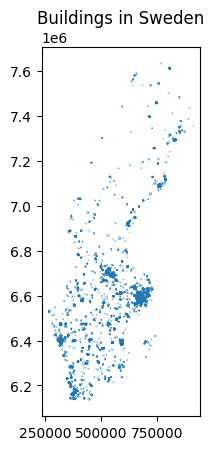

In [70]:
meta.boundary.plot()
plt.title('Buildings in Sweden')

In [73]:
#looping through 1000x1000 squares of the data and collecting variances and means of level-data
import time

start = time.time()
x = 250000
size = 1000

count = []
means = []
variances = []

while x < 850000-size:
    y = 6100000
    while y < 7600000-size:
        if reg.cx[x:x+size, y:y+size].shape[0] > 10:
            means.append(reg.cx[x:x+size, y:y+size]['building:levels'].astype(float).mean())
            variances.append(reg.cx[x:x+size, y:y+size]['building:levels'].astype(float).var())
            count.append(reg.cx[x:x+size, y:y+size].shape[0])
        y += size
        #print(x,y)
    x += size
end = time.time()
print(end - start)

1235.398022890091


In [74]:
squares = pd.DataFrame({'Count': count, 'Means': means, 'Variance': variances})
squares

,Count,Means,Variance
0,11,1.090909,0.090909
1,11,2.000000,0.000000
2,30,1.833333,1.660920
3,85,1.741176,0.360784
4,70,2.157143,1.554658
...,...,...,...
287,130,1.761538,2.353548
288,15,2.733333,2.495238
289,30,1.533333,0.464368
290,12,1.333333,0.424242


In [75]:
#the variation in levels within 1000x1000meter squares
squares['Variance'].mean()

2.5293782859473533

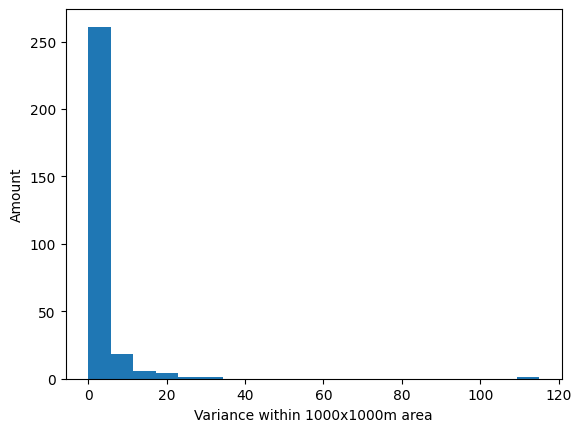

In [81]:
#histogram of different variances within 1000x1000m squares
plt.hist(squares['Variance'], bins=20)
plt.ylabel('Amount')
plt.xlabel('Variance within 1000x1000m area')
plt.show()

In [84]:
squares2 = squares[squares['Variance'] < 40]
squares2['Variance'].mean()

2.142818823637269

(array([201.,  33.,  17.,  12.,   6.,   4.,   3.,   4.,   3.,   0.,   1.,
          3.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 0.        ,  1.53904762,  3.07809524,  4.61714286,  6.15619048,
         7.6952381 ,  9.23428571, 10.77333333, 12.31238095, 13.85142857,
        15.39047619, 16.92952381, 18.46857143, 20.00761905, 21.54666667,
        23.08571429, 24.6247619 , 26.16380952, 27.70285714, 29.24190476,
        30.78095238]),
 <BarContainer object of 20 artists>)

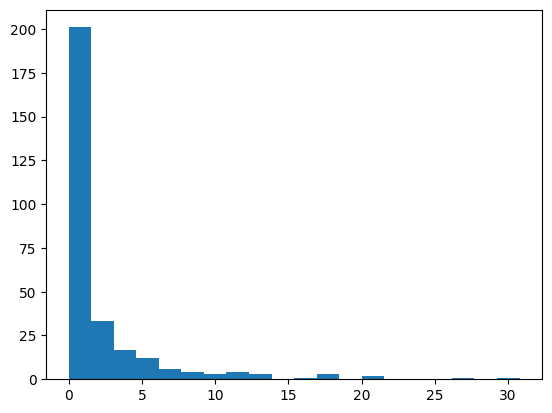

In [85]:
plt.hist(squares2['Variance'], bins=20)

In [76]:
reg['building:levels'].astype('float').var()

3.4564278640936545

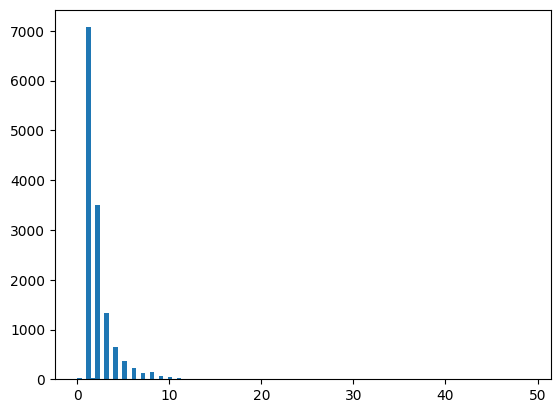

In [80]:
plt.hist(reg['building:levels'].astype('float'), bins=100)
plt.show()

In [86]:
#looping through 1000x1000 squares of the data and collecting variances and means of level-data

start = time.time()
x = 250000
size = 500

count2 = []
means2 = []
variances2 = []

while x < 850000-size:
    y = 6100000
    while y < 7600000-size:
        if reg.cx[x:x+size, y:y+size].shape[0] > 1:
            means2.append(reg.cx[x:x+size, y:y+size]['building:levels'].astype(float).mean())
            variances2.append(reg.cx[x:x+size, y:y+size]['building:levels'].astype(float).var())
            count2.append(reg.cx[x:x+size, y:y+size].shape[0])
        y += size
        #print(x,y)
    x += size
end = time.time()
print(end - start)

4976.348487377167


In [87]:
squares3 = pd.DataFrame({'Count': count2, 'Means': means2, 'Variance': variances2})
squares3['Variance'].mean()

2.21379218185766